In [3]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['SimHei']

def toInt(s):
    return int(s) // 10000

df = pd.read_csv("./score.csv")

model = df['model']
data = df['scores']
score = [[toInt(num) for num in d.split(" ")] for d in data]
score = list(score)

# for s in score:
#     a = np.array(s)
#     print(a.max())


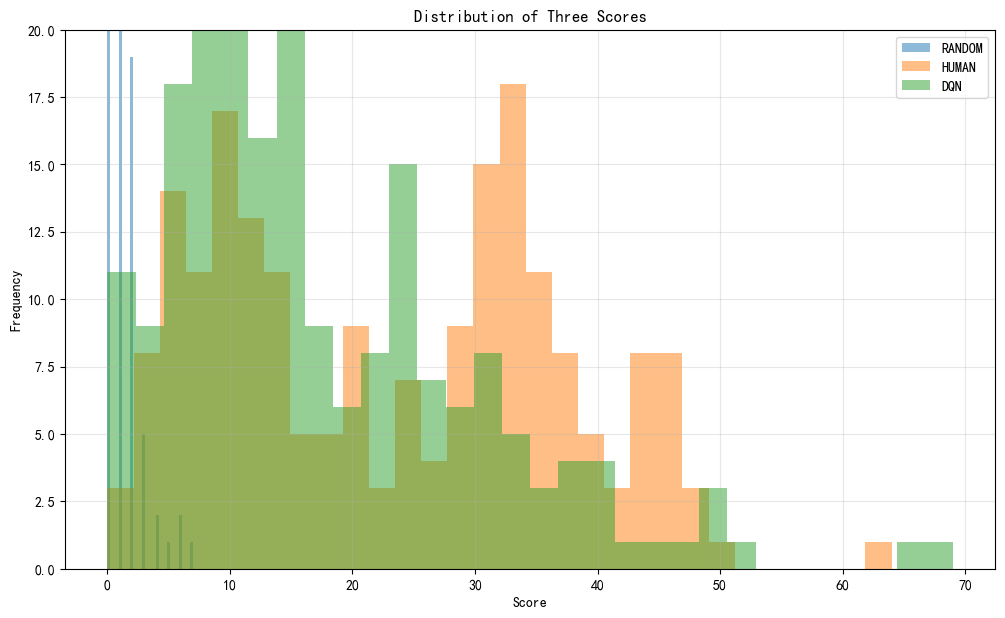

In [6]:
plt.figure(figsize=(12, 7))

# 绘制三个分布
for i in range(0, 3):
    plt.hist(score[i], bins=30, alpha=0.5, label=model[i])


plt.title('Distribution of Three Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.ylim(0, 20)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

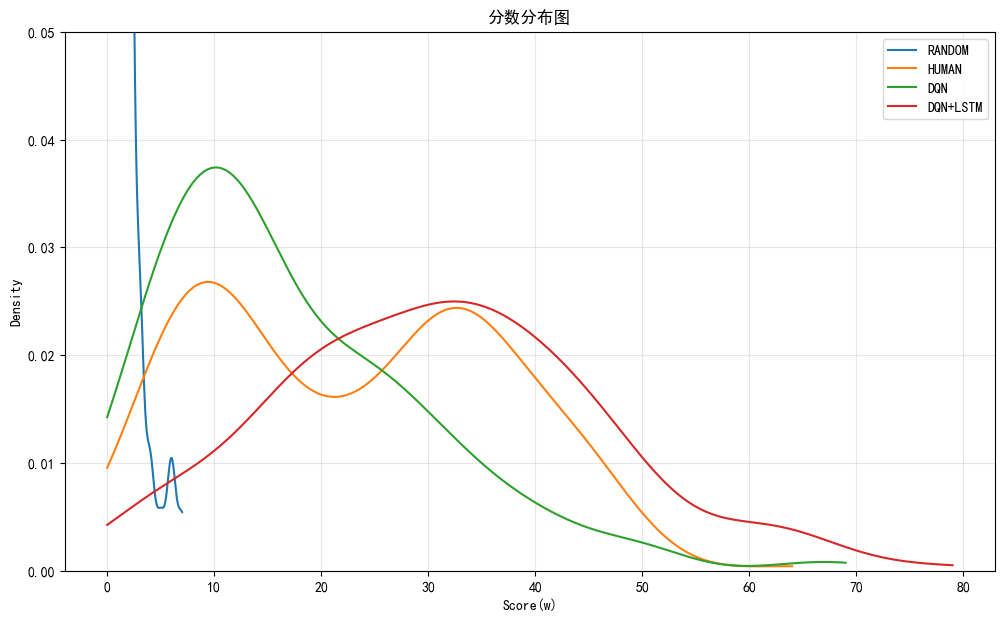

In [11]:
plt.figure(figsize=(12, 7))

# 为每个分数集计算核密度估计
for i, s in enumerate(score):
    density = stats.gaussian_kde(s)
    xs = np.linspace(min(s), max(s), 200)
    plt.plot(xs, density(xs), label=f'{model[i]}')

plt.title('分数分布图')
plt.xlabel('Score(w)')
plt.ylabel('Density')
plt.ylim(0, 0.05)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

RANDOM: Mean = 0.63, Std = 1.14
HUMAN: Mean = 23.17, Std = 13.78
DQN: Mean = 17.39, Std = 12.61
DQN+LSTM: Mean = 30.99, Std = 15.06


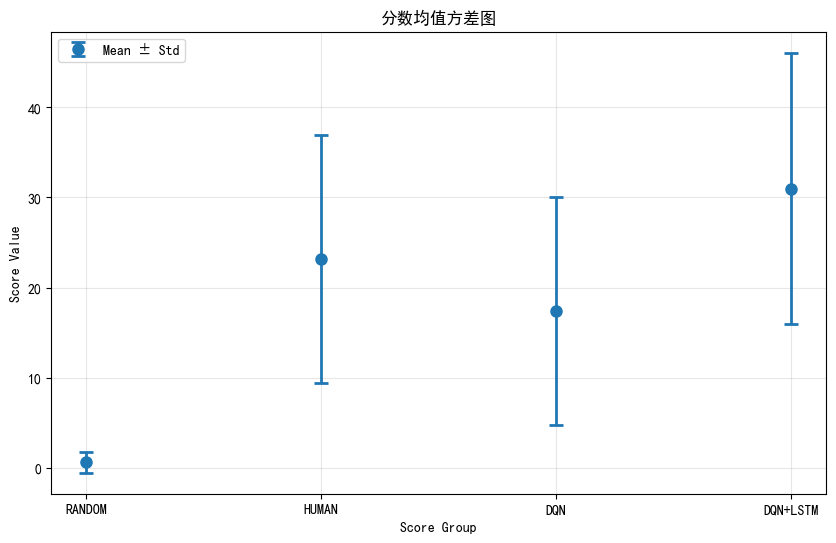

In [13]:
plt.figure(figsize=(10, 6))

# 计算每个分数集的均值和标准差
means = [np.mean(s) for s in score]
stds = [np.std(s) for s in score]

# 绘制误差棒图
plt.errorbar(range(1, len(df)+1), means, yerr=stds, fmt='o', capsize=5, capthick=2, 
             elinewidth=2, markersize=8, label='Mean ± Std')

# 美化图表
plt.xticks(range(1, len(df)+1), model)
plt.title('分数均值方差图')
plt.xlabel('Score Group')
plt.ylabel('Score Value')
plt.grid(True, alpha=0.3)
plt.legend()

# 打印具体数值
for i, (mean, std) in enumerate(zip(means, stds)):
    print(f'{model[i]}: Mean = {mean:.2f}, Std = {std:.2f}')

plt.show()

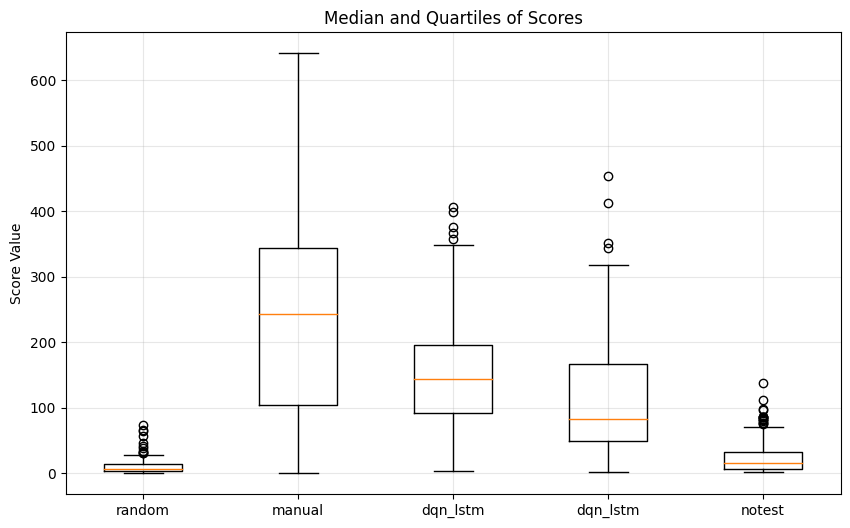

In [7]:
# ... existing code ...
plt.figure(figsize=(10, 6))

# 绘制箱线图
plt.boxplot(score, labels=model)

# 美化图表
plt.title('Median and Quartiles of Scores')
plt.ylabel('Score Value')
plt.grid(True, alpha=0.3)
plt.show()
# ... existing code ...

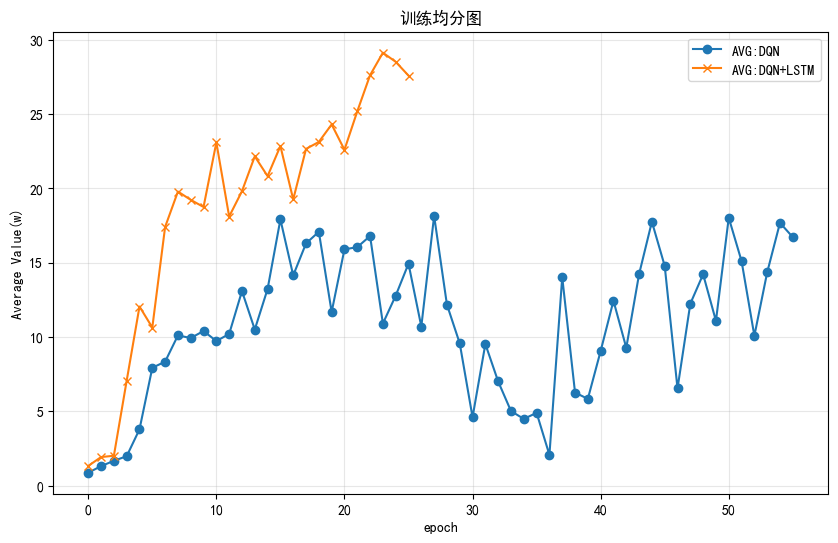

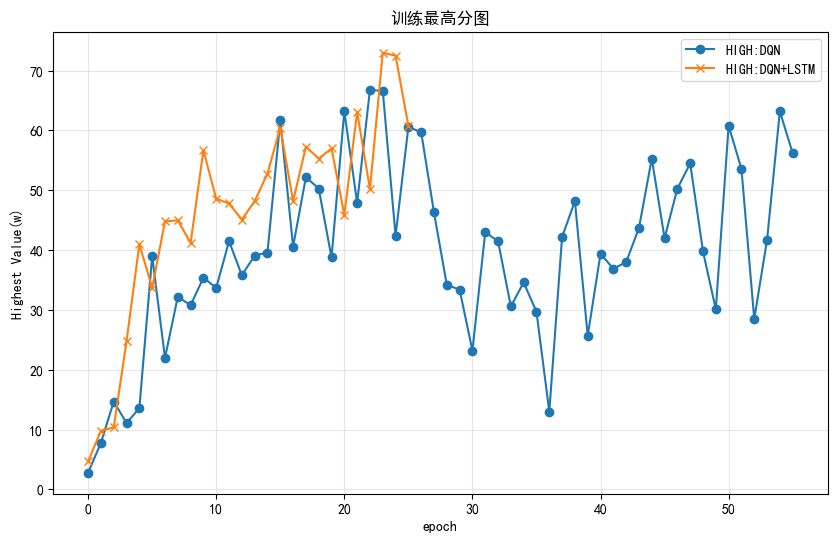

In [12]:
# 读取文件
def read_file(file):
    with open(file, "r", encoding='utf-8') as f:
        data = f.readlines()
        avg = []
        high = []
        for d in data:
            info = d.strip("\n").split(" ")
            avg.append(float(info[0]) / 10000)
            high.append(float(info[1]) / 10000)
    return avg, high

avg1, high1 = read_file("dqn.txt")
avg2, high2 = read_file("dqn_lstm.txt")

plt.figure(figsize=(10, 6))

# 绘制 avg1 和 avg2 的折线图
plt.plot(avg1, label='AVG:DQN', marker='o')
plt.plot(avg2, label='AVG:DQN+LSTM', marker='x')  # 直接绘制 avg2

# 美化title('Line Plot of Avg1 and Avg2')
plt.xlabel('epoch')
plt.ylabel('Average Value(w)')
plt.title("训练均分图")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()



plt.figure(figsize=(10, 6))

# 绘制 avg1 和 avg2 的折线图
plt.plot(high1, label='HIGH:DQN', marker='o')
plt.plot(high2, label='HIGH:DQN+LSTM', marker='x')  # 直接绘制 avg2

# 美化title('Line Plot of Avg1 and Avg2')
plt.xlabel('epoch')
plt.ylabel('Highest Value(w)')
plt.title("训练最高分图")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()